In [62]:
from utils import set_save_path, mkdir_for_model
from simulutils import *
from data_gen import Data_gen
import sys
sys.path.append('./models/')
from Residual_FC_model import Residual_FC_classifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import os
def CAGR(res):
    # CAGR 계산
    return res.values[-1] ** (1/ (res.index[-1] - res.index[0]).days * 360)-1
def make_columns(dataset, use_cols, adds=['standard', 'gr', 'rank'], include_mean_std = True):
    scaled_data = dataset[use_cols].T.reset_index().set_index(['level_1', 'level_0']).sort_index().T.stack().T
    new_df = []
    for add in adds:
        if add == 'gr':
            eps = 0.0001
            upper = 1 - eps
            lower = -1 + eps
            data = erfinv(scaled_data.rank(1, method='max', pct=True) * (upper - lower) - upper)
            data = transform_dataset(data, add)

        elif add == 'rank':
            data = scaled_data.rank(1, pct=True)
            data = transform_dataset(data, add)

        elif add == 'standard':
            mean_data = pd.DataFrame(columns=scaled_data.columns, index=scaled_data.index)

            mean_data.iloc[0] = scaled_data.mean()

            mean_data.ffill(inplace=True)

            std_data = pd.DataFrame(columns=scaled_data.columns, index=scaled_data.index)

            std_data.iloc[0] = scaled_data.std()

            std_data.ffill(inplace=True)

            data = (scaled_data - mean_data) / std_data

            data = transform_dataset(data, add)
            if include_mean_std:
                mean_data = transform_dataset(mean_data, 'mean')
                std_data = transform_dataset(std_data, 'std')

                new_df.append(mean_data)
                new_df.append(std_data)

        new_df.append(data)
    return pd.concat(new_df, 1)
def transform_dataset(data, name):
    """
        데이터셋 만들고 원래 모양으로 되돌려주는 함수
    """
    try:
        data = data.stack().reset_index().set_index(['level_0', 'level_1']).sort_index().T.stack()
    except KeyError:
        level_0, level_1 = data.stack().reset_index().columns[:2]
        data = data.stack().reset_index().set_index([level_0, level_1]).sort_index().T.stack()

    data.columns = list(map(lambda x: x + '_{}'.format(name), data.columns))

    return data.unstack()

In [64]:
model_name= '11016'
comment = """
    XGBOOST로 하되 데이터 약간 늘림(9개월 추가 등)
    데이터 생성 실시, market cap 상위200
    
"""

In [65]:
train_days = 3* 12
test_days = 3
use_all_past = True

In [66]:
data_gen = Data_gen(how = None, extreme= True)
whole_data, ca, ret_data_, index = data_gen.load_data()
onehot = OneHotEncoder()

/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [67]:
whole_data = whole_data.loc['20070102':]

not_scale = ['ret_1m', 'ret_1m_sig','ret_1m_lag', 'ret_1m_sig_lag', 'MCAP', '800180']

rest_data = whole_data[not_scale]

use_cols = ['ret_20d', 'ret_40d', 'ret_60d', 'ret_120d', 'ret_180d']

new_data = make_columns(whole_data, use_cols)

use_cols2 = ['201800', '201900', 'vol_20d', 'vol_40d', 'vol_60d', 'vol_120d', 'vol_240d']

new_data2 = make_columns(whole_data, use_cols2, include_mean_std=False)

whole_data = pd.concat([rest_data, new_data, new_data2], 1)

whole_data.index = pd.to_datetime(whole_data.index)

whole_data = whole_data.stack()
dummies = pd.get_dummies(whole_data['ret_1m_sig_lag'].dropna().astype(int))
dummies.columns = [f'quan_{i}' for i in range(10)]
whole_data = pd.concat([whole_data, dummies], 1).drop('ret_1m_sig_lag', 1)

whole_data = whole_data.unstack()

In [68]:
mkt_filter = whole_data['800180'] > 300 & (whole_data['MCAP'] > 1000)

In [69]:
mkt_filter = whole_data['MCAP'].rank(1, ascending = False)<= 200

In [70]:
filtered_data = {}
for i in whole_data.columns.levels[0]:
    filtered_data[i] = whole_data[i][mkt_filter]

In [71]:
whole_data = pd.concat(filtered_data, 1)

In [72]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

activate = XGBClassifier(max_depth = 10, n_estimators = 500, learning_rate = 0.01,  n_jobs = -1, nthread=-1)
# activate = ExtraTreesClassifier(max_depth = 10, n_estimators = 300, n_jobs = -1)
# activate = LGBMClassifier(max_depth = 10, n_estimators = 300, learning_rate = 0.001, n_jobs = -1)



# 저장용 경로 생성 및 반환
save_path, model_path = mkdir_for_model(model_name)
ensemble_count = 1


for i in range(ensemble_count):
    reset_cursor = 0
    wb = window_batch(whole_data)
    wb.reset_cursor(reset_cursor)
    # 모델의 각 기간별 도출되는 signal output들 저장
    test_signals = []
    best_signals = []

    # while window data is available
    while (wb.check_window(train_days + 1)):
        # Get train data
        train_XY = wb.next_n_batch(train_days)
        if use_all_past:
            train_XY = whole_data.iloc[:reset_cursor + train_days].stack()

        # Get test data
        test_XY = wb.next_n_batch(test_days)
        # scaling with trian and test_data
        #         ts_scaling(pd.concat([train_XY, test_XY]), ex_cols = ['ret_4w', 'sector'], how = how)
        
        Y_train = train_XY.loc[:, 'ret_1m_sig'].dropna()  # train_XY.loc[:, 'ret_1m_sig'].dropna()
        X_train = train_XY.loc[
            Y_train.index, (train_XY.columns != 'ret_1m') & (train_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values

        Y_test = test_XY.loc[:, 'ret_1m_lag'].dropna()  # use one column to dropnas
        # TODO median 체크
        X_test = test_XY.loc[
            Y_test.index, (test_XY.columns != 'ret_1m') & (test_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values
       
        
#         Y_train = train_XY.loc[:, 'ret_1m_sig'].dropna()  # train_XY.loc[:, 'ret_1m_sig'].dropna()
#         X_train = train_XY.loc[
#             Y_train.index, (train_XY.columns != 'ret_1m') & (train_XY.columns != 'ret_1m_sig')].dropna()
#         Y_train = Y_train.reindex(X_train.index)
#         X_train = X_train.values
        
#         Y_test = test_XY.loc[:, 'ret_1m_lag'].dropna()  # use one column to dropnas
#         # TODO median 체크
#         X_test = test_XY.loc[
#             Y_test.index, (test_XY.columns != 'ret_1m') & (test_XY.columns != 'ret_1m_sig')].dropna()
#         Y_test = Y_test.reindex(X_test.index)
#         X_test = X_test.values
        
        
        y_train_onehot = onehot.fit_transform(np.expand_dims(Y_train.astype(int), -1)).toarray()
        print(X_train.shape, Y_train.shape)
        # 모델에서 사용하는 저장 경로
        activate.fit(X_train, Y_train)
        
        # 학습 완료된 학습 predict proba
        predict_proba = activate.predict_proba(X_test)

#         print(np.bincount(predict_proba>0.5))
        print(activate.score(X_train, Y_train))
        #         print(activate.score(X_train, Y_train))
        #         print(accuracy_score((train_pred>0.5),Y_train.values))
        test_signals.append(pd.DataFrame(predict_proba, index=Y_test.index))

        # reset cursor
        reset_cursor = reset_cursor + test_days

        wb.reset_cursor(reset_cursor)

    #         del activate
    # 각 모델 학습 끝날때마다 위 저장경로에 signal 데이터 저장
    #     pd.concat(best_signals).unstack().to_csv('{}/best_signals_{}.csv'.format(params['model_path'], i))



/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2640, 59) (2640,)
0.9981060606060606


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2731, 59) (2731,)
0.9985353350421091


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2832, 59) (2832,)
0.9982344632768362


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2922, 59) (2922,)
0.9976043805612594


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3027, 59) (3027,)
0.998017839444995


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3129, 59) (3129,)
0.9990412272291467


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3227, 59) (3227,)
0.9987604586303068


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3332, 59) (3332,)
0.9972989195678271


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3453, 59) (3453,)
0.9979727772951057


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3562, 59) (3562,)
0.9985962942167321


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3663, 59) (3663,)
0.9983619983619983


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3780, 59) (3780,)
0.9947089947089947


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(3894, 59) (3894,)
0.9971751412429378


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4032, 59) (4032,)
0.9933035714285714


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4139, 59) (4139,)
0.9937182894418942


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4259, 59) (4259,)
0.9941300774829772


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4381, 59) (4381,)
0.9915544396256563


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4484, 59) (4484,)
0.9915254237288136


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4613, 59) (4613,)
0.9906785172339042


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4740, 59) (4740,)
0.9911392405063291


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4861, 59) (4861,)
0.9932112734005348


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(4967, 59) (4967,)
0.9871149587276021


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5098, 59) (5098,)
0.9901922322479404


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5238, 59) (5238,)
0.9883543337151585


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5367, 59) (5367,)
0.9932923420905534


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5484, 59) (5484,)
0.9897884755652808


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5586, 59) (5586,)
0.9908700322234156


In [73]:
 ts = pd.concat(test_signals)

In [74]:
pd.concat(test_signals).unstack().to_csv('{}/test_signals_{}.csv'.format(model_path, i))

print(model_name)
transact_fee = 0.004
bt_fromdate = '2010'


11016


In [75]:
test_prob = ts.iloc[:, 1].unstack()

In [92]:
kospi = pd.read_excel('./data/kospi.xlsx', sheet_name = 'kospi200')

In [93]:
k200 = kospi.set_index('D A T E')

In [94]:
k200.index = pd.to_datetime(k200.index)

In [95]:
k200 = (k200.reindex(res.index).pct_change().fillna(0) + 1).cumprod()

In [98]:
k200.plot()

In [77]:



# 0인 값들은 nan 으로 변환
test_prob = test_prob[test_prob != 0]
test_prob.columns.name = 'code'
sig_data = qcut_signal(test_prob, 10, test_prob.index[0])
sig_data = sig_data.pivot(index='tdate', columns='code', values='value')
sig_data = sig_data.loc[bt_fromdate:]
sig_data.index = pd.to_datetime(sig_data.index)

ress = []
tr_ress = []
mdds = []
turnovers = []
cagrs = []
tr_cagrs = []
sharpes = []
tr_sharpes = []
ports = []
rtn = ret_data_.copy()
for signal in range(10):
    weight_sig_data = sig_data.copy().apply(long_only_sig_to_weight, axis=1, args=(signal, 1)).loc[bt_fromdate:]

    # weight_sig_data = sig_dataa

    rtn_ = rtn.reindex(columns=weight_sig_data.columns)

    #     rtn_ = rtn_.loc['2010':]

    rep_ = weight_sig_data[weight_sig_data != 0]

    # rep_ = sig_data

    port_ = rep_

    port_.fillna(0, inplace=True)

    columns = rep_.columns  # 종목리스트

    ret_data_ = rtn.loc[port_.index[0]:'20190724']  # 해당 기간 맵핑
    ret_data_ = ret_data_.reindex(columns=columns)  # 종목 일치

    port_ = port_.reindex(ret_data_.index)  # 포트폴리오 기간 맵핑
    port_.columns = columns  # 종목 맵핑

    port_ = port_.ffill()  # 포트폴리오를 계속 가져간다고 가정

    a = ret_data_ * port_  # 수익률에 포트폴리오 product
    a = a.sum(1)  # and sum

    turnover = rep_.diff()  # turnover 계산
    turnover.iloc[0] = port_.iloc[0]
    # 거래비용 참조
    trade_cost = turnover[turnover > 0].sum(1) * transact_fee / 2 - turnover[turnover < 0].sum(
        1) * transact_fee / 2

    # 매 포트가 변할때마다 trade_cost 발생
    a2 = a - trade_cost.reindex(a.index).fillna(0)

    a.iloc[0] = 0
    res = (a + 1).cumprod()  # 거래세 고려 x performance

    a2.iloc[0] = 0
    res_tr = (a2 + 1).cumprod()  # 거래세 고려  performance

    TO = (abs(turnover).sum(1) / 2).resample('Y').sum().mean()  # 연간 회전율 평균
    MDD = (res / res.cummax() - 1).min()  # MDD
    CAGR_ = CAGR(res)
    CAGR_tr = CAGR(res_tr)
    sharpe = np.mean(res.pct_change().dropna()) / np.std(res.pct_change().dropna()) * np.sqrt(252)
    sharpe_tr = np.mean(res_tr.pct_change().dropna()) / np.std(res.pct_change().dropna()) * np.sqrt(252)
    port = rep_[rep_ != 0].reset_index().melt('tdate').dropna()
    port['stock_nm'] = ca.set_index('code').kn.reindex(port.code.values).values
    port['code'] = port['code'].apply(lambda x: 'A' + x)
    sharpes.append(sharpe)
    tr_sharpes.append(sharpe_tr)
    mdds.append(MDD)
    turnovers.append(TO)
    tr_cagrs.append(CAGR_tr)
    cagrs.append(CAGR_)
    ports.append(port)
    tr_ress.append(res_tr)
    ress.append(res)




data = {}
data['start_date'] = res.index[0]
data['end_date'] = res.index[-1]
data['RETURN'] = res.iloc[-1]
data['RETURN_tr'] = res_tr.iloc[-1]
data['mdd'] = MDD
data['turnover'] = TO
data['CAGR'] = CAGR_
data['CAGR_tr'] = CAGR_tr
data['sharpe'] = sharpe
data['sharpe_tr'] = sharpe_tr
data['model'] = activate

data['qcut'] = 10
data['comment'] = comment
writer = pd.ExcelWriter('./training_result/{}/{}_summary.xlsx'.format(model_name, model_name), engine='xlsxwriter')

pd.Series(data).to_excel(writer, sheet_name='summary')
res.to_excel(writer, sheet_name='perfor')
res_tr.to_excel(writer, sheet_name='tr_perfor')
(1 + res.pct_change().fillna(0)).resample('Y').prod().to_excel(writer, sheet_name='Yearly')
(1 + res_tr.pct_change().fillna(0)).resample('Y').prod().to_excel(writer, sheet_name='Yearly_tr')

port['전월수익률'] = port.apply(lambda x: whole_data['ret_1m_lag'].loc[x.tdate, x.code[1:]], 1)
port['익월수익률'] = port.apply(lambda x: whole_data['ret_1m'].loc[x.tdate, x.code[1:]], 1)
port['시가총액(억)'] = port.apply(lambda x: whole_data['MCAP'].loc[x.tdate, x.code[1:]], 1)
port['거래대금(백만)'] = port.apply(lambda x: whole_data['800180'].loc[x.tdate, x.code[1:]], 1)

port.sort_values('tdate').dropna().to_excel(writer, encoding='euc_kr', index=False, sheet_name='portfolio')
# pd.Series(activate.params).to_excel(writer, sheet_name = 'parameter_setting')
writer.close()


writer = pd.ExcelWriter('./training_result/{}/{}_summary_all.xlsx'.format(model_name, model_name),
                        engine='xlsxwriter')

ress = pd.concat(ress, 1)
tr_ress = pd.concat(tr_ress, 1)

pd.DataFrame([ress.iloc[-1].values, tr_ress.iloc[-1].values, mdds, turnovers, cagrs, tr_cagrs, sharpes, tr_sharpes],
             index = ['RETURN', 'RETURN_TR', 'MDD', 'TURNOVER', 'CAGR', 'CAGR_TR', 'SHARPE', 'SHARPE_TR']).to_excel(writer, sheet_name = 'summary')

ress.to_excel(writer, sheet_name = 'performance')
tr_ress.to_excel(writer, sheet_name = 'performance_tr')


# pd.Series(activate.params).to_excel(writer, sheet_name = 'parameter_setting')
writer.close()

In [45]:
test_prob = test_prob[whole_data['MCAP'].rank(1, ascending = False)<= 200]

In [157]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

activate = XGBClassifier(max_depth = 10, n_estimators = 500, learning_rate = 0.01, n_jobs = -1, nthread=-1)
# activate = ExtraTreesClassifier(max_depth = 10, n_estimators = 300, n_jobs = -1)
# activate = LGBMClassifier(max_depth = 10, n_estimators = 300, learning_rate = 0.001, n_jobs = -1)



# 저장용 경로 생성 및 반환
save_path, model_path = mkdir_for_model(model_name)
ensemble_count = 1


for i in range(ensemble_count):
    reset_cursor = 0
    wb = window_batch(whole_data)
    wb.reset_cursor(reset_cursor)
    # 모델의 각 기간별 도출되는 signal output들 저장
    test_signals = []
    best_signals = []

    # while window data is available
    while (wb.check_window(train_days + 1)):
        # Get train data
        train_XY = wb.next_n_batch(train_days)
        if use_all_past:
            train_XY = whole_data.iloc[:reset_cursor + train_days].stack()

        # Get test data
        test_XY = wb.next_n_batch(test_days)
        # scaling with trian and test_data
        #         ts_scaling(pd.concat([train_XY, test_XY]), ex_cols = ['ret_4w', 'sector'], how = how)

        Y_train = train_XY.loc[:, 'ret_1m_sig'].dropna()  # train_XY.loc[:, 'ret_1m_sig'].dropna()
        X_train = train_XY.loc[
            Y_train.index, (train_XY.columns != 'ret_1m') & (train_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values

        Y_test = test_XY.loc[:, 'ret_1m_lag'].dropna()  # use one column to dropnas
        # TODO median 체크
        X_test = test_XY.loc[
            Y_test.index, (test_XY.columns != 'ret_1m') & (test_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values

        y_train_onehot = onehot.fit_transform(np.expand_dims(Y_train.astype(int), -1)).toarray()
        print(X_train.shape, Y_train.shape)
        # 모델에서 사용하는 저장 경로
        activate.fit(X_train, Y_train)
        
        # 학습 완료된 학습 predict proba
        predict_proba = activate.predict_proba(X_test)[:, 1]

        print(np.bincount(predict_proba>0.5))
        print(activate.score(X_train, Y_train))
        #         print(activate.score(X_train, Y_train))
        #         print(accuracy_score((train_pred>0.5),Y_train.values))
        test_signals.append(pd.Series(predict_proba, index=Y_test.index))

        # reset cursor
        reset_cursor = reset_cursor + test_days

        wb.reset_cursor(reset_cursor)

    #         del activate
    # 각 모델 학습 끝날때마다 위 저장경로에 signal 데이터 저장
    #     pd.concat(best_signals).unstack().to_csv('{}/best_signals_{}.csv'.format(params['model_path'], i))



/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(3291, 18) (3291,)
[1020 1044]
0.9930112427833485


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(3708, 18) (3708,)
[ 971 1093]
0.9911003236245954


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(4127, 18) (4127,)
[ 883 1199]
0.9927307971892416


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(4546, 18) (4546,)
[ 830 1275]
0.9894412670479542


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(4972, 18) (4972,)
[1108 1004]
0.9853177795655672


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(4996, 18) (4996,)
[ 899 1224]
0.9865892714171337


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5020, 18) (5020,)
[1274  872]
0.9854581673306773


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5043, 18) (5043,)
[1491  658]
0.9847313107277414


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5060, 18) (5060,)
[1515  622]
0.9796442687747036


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5073, 18) (5073,)
[1099 1042]
0.984033116499113


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5091, 18) (5091,)
[ 647 1495]
0.9856609703398154


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5106, 18) (5106,)
[ 595 1562]
0.9864864864864865


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5119, 18) (5119,)
[ 666 1488]
0.9882789607345185


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5133, 18) (5133,)
[ 671 1481]
0.9937658289499318


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5147, 18) (5147,)
[ 517 1652]
0.9930056343501069


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5166, 18) (5166,)
[ 520 1661]
0.9938056523422377


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5180, 18) (5180,)
[ 778 1402]
0.9932432432432432


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5192, 18) (5192,)
[ 919 1275]
0.9921032357473035


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5207, 18) (5207,)
[1278  923]
0.9923180334165547


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5221, 18) (5221,)
[1055 1148]
0.9917640298793334


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5232, 18) (5232,)
[ 731 1472]
0.9879587155963303


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5242, 18) (5242,)
[ 813 1384]
0.9885539870278519


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5254, 18) (5254,)
[ 674 1520]
0.9916254282451465


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5266, 18) (5266,)
[ 743 1444]
0.996202050892518


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5271, 18) (5271,)
[ 680 1486]
0.9941187630430658


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5274, 18) (5274,)
[ 643 1516]
0.9914675767918089


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5276, 18) (5276,)
[ 663 1501]
0.9909021986353298


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5275, 18) (5275,)
[ 675 1499]
0.9888151658767772


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5273, 18) (5273,)
[ 723 1434]
0.9948795751943865


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5268, 18) (5268,)
[ 777 1394]
0.9933561123766135


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5262, 18) (5262,)
[ 859 1321]
0.9960091220068416


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5259, 18) (5259,)
[ 968 1213]
0.993915193002472


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5261, 18) (5261,)
[1049 1134]
0.9969587530887664


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5263, 18) (5263,)
[1151 1035]
0.9927797833935018


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5262, 18) (5262,)
[1192 1001]
0.9904979095400989


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5262, 18) (5262,)
[1149 1059]
0.9899277841125047


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5273, 18) (5273,)
[1183 1019]
0.9926038308363361


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5284, 18) (5284,)
[1124 1087]
0.9905374716124148


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5296, 18) (5296,)
[ 997 1229]
0.9905589123867069


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5306, 18) (5306,)
[ 995 1239]
0.9911421032793064


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5318, 18) (5318,)
[ 841 1380]
0.9885295223768334


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5335, 18) (5335,)
[ 656 1587]
0.9844423617619494


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5348, 18) (5348,)
[ 782 1459]
0.9846671652954375


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5357, 18) (5357,)
[ 857 1407]
0.9873063281687512


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5366, 18) (5366,)
[ 991 1279]
0.9873276183376817


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5383, 18) (5383,)
[ 969 1309]
0.9890395690135612


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5397, 18) (5397,)
[ 955 1344]
0.985176950157495


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5414, 18) (5414,)
[1026 1273]
0.9865164388622091


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5427, 18) (5427,)
[ 881 1416]
0.984337571402248


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



(5443, 18) (5443,)
[574 956]
0.9904464449751975


In [158]:
port['ret'] = port['익월수익률'] * port['value']

In [159]:
    pd.concat(test_signals).unstack().to_csv('{}/test_signals_{}.csv'.format(model_path, i))

    print(model_name)
    transact_fee = 0.004
    bt_fromdate = '2010'


11010


In [147]:
test_prob = pd.concat(test_signals).unstack()

In [109]:
MDD = (res / res.cummax() - 1).min()

In [118]:
dd = (res / res.cummax() - 1)

In [122]:
import cufflinks as cf
cf.set_config_file(offline = True)

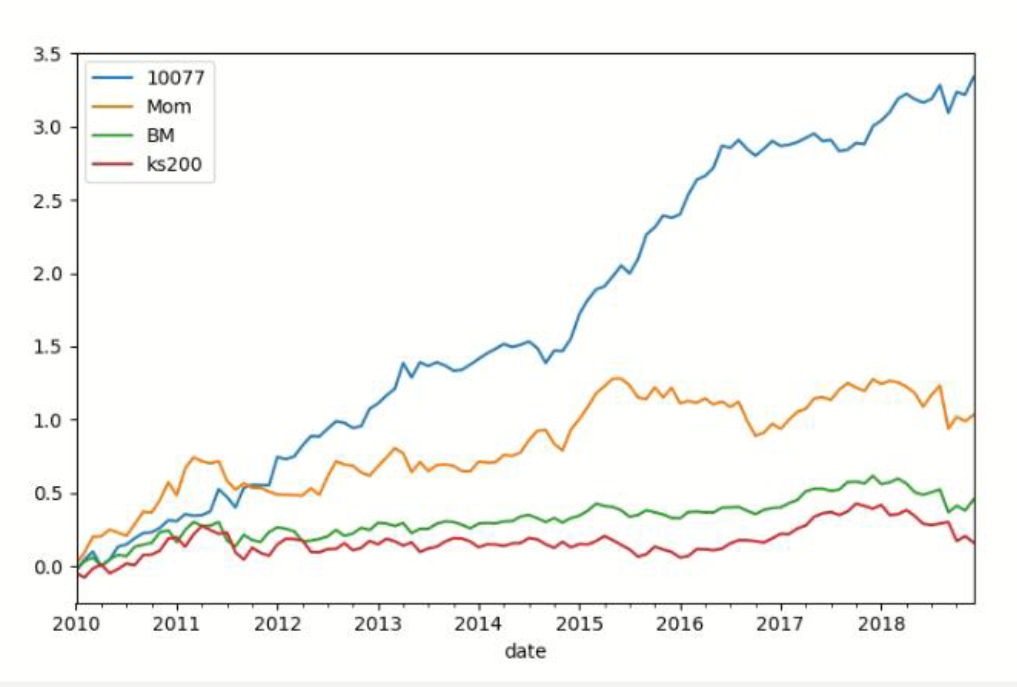

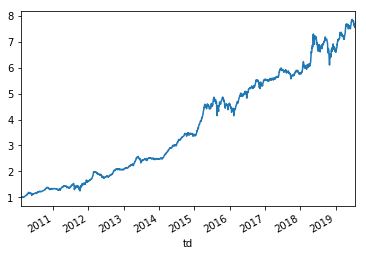

In [127]:
res.plot()

In [120]:
dd[:dd.idxmin()]

td
2010-01-29    0.000000
2010-02-01   -0.001336
2010-02-02   -0.001283
2010-02-03    0.000000
2010-02-04    0.000000
2010-02-05   -0.016034
2010-02-08   -0.014941
2010-02-09   -0.011440
2010-02-10   -0.014187
2010-02-11   -0.010456
2010-02-12   -0.005775
2010-02-16    0.000000
2010-02-17    0.000000
2010-02-18   -0.002673
2010-02-19   -0.012234
2010-02-22   -0.000972
2010-02-23    0.000000
2010-02-24   -0.003348
2010-02-25   -0.008702
2010-02-26   -0.006553
2010-03-02   -0.005769
2010-03-03   -0.002581
2010-03-04   -0.002417
2010-03-05    0.000000
2010-03-08    0.000000
2010-03-09    0.000000
2010-03-10    0.000000
2010-03-11    0.000000
2010-03-12    0.000000
2010-03-15    0.000000
                ...   
2011-08-22   -0.111149
2011-08-23   -0.094806
2011-08-24   -0.097631
2011-08-25   -0.090055
2011-08-26   -0.085694
2011-08-29   -0.070821
2011-08-30   -0.064091
2011-08-31   -0.052499
2011-09-01   -0.054807
2011-09-02   -0.057999
2011-09-05   -0.079571
2011-09-06   -0.088350
2011-09-

In [160]:



# 0인 값들은 nan 으로 변환
test_prob = test_prob[test_prob != 0]
test_prob.columns.name = 'code'
sig_data = qcut_signal(test_prob, 10, test_prob.index[0])
sig_data = sig_data.pivot(index='tdate', columns='code', values='value')
sig_data = sig_data.loc[bt_fromdate:]
sig_data.index = pd.to_datetime(sig_data.index)

ress = []
tr_ress = []
mdds = []
turnovers = []
cagrs = []
tr_cagrs = []
sharpes = []
tr_sharpes = []
ports = []
rtn = ret_data_.copy()
for signal in range(10):
    weight_sig_data = sig_data.copy().apply(long_only_sig_to_weight, axis=1, args=(signal, 1)).loc[bt_fromdate:]

    # weight_sig_data = sig_dataa

    rtn_ = rtn.reindex(columns=weight_sig_data.columns)

    #     rtn_ = rtn_.loc['2010':]

    rep_ = weight_sig_data[weight_sig_data != 0]

    # rep_ = sig_data

    port_ = rep_

    port_.fillna(0, inplace=True)

    columns = rep_.columns  # 종목리스트

    ret_data_ = rtn.loc[port_.index[0]:'20190724']  # 해당 기간 맵핑
    ret_data_ = ret_data_.reindex(columns=columns)  # 종목 일치

    port_ = port_.reindex(ret_data_.index)  # 포트폴리오 기간 맵핑
    port_.columns = columns  # 종목 맵핑

    port_ = port_.ffill()  # 포트폴리오를 계속 가져간다고 가정

    a = ret_data_ * port_  # 수익률에 포트폴리오 product
    a = a.sum(1)  # and sum

    turnover = rep_.diff()  # turnover 계산
    turnover.iloc[0] = port_.iloc[0]
    # 거래비용 참조
    trade_cost = turnover[turnover > 0].sum(1) * transact_fee / 2 - turnover[turnover < 0].sum(
        1) * transact_fee / 2

    # 매 포트가 변할때마다 trade_cost 발생
    a2 = a - trade_cost.reindex(a.index).fillna(0)

    a.iloc[0] = 0
    res = (a + 1).cumprod()  # 거래세 고려 x performance

    a2.iloc[0] = 0
    res_tr = (a2 + 1).cumprod()  # 거래세 고려  performance

    TO = (abs(turnover).sum(1) / 2).resample('Y').sum().mean()  # 연간 회전율 평균
    MDD = (res / res.cummax() - 1).min()  # MDD
    CAGR_ = CAGR(res)
    CAGR_tr = CAGR(res_tr)
    sharpe = np.mean(res.pct_change().dropna()) / np.std(res.pct_change().dropna()) * np.sqrt(252)
    sharpe_tr = np.mean(res_tr.pct_change().dropna()) / np.std(res.pct_change().dropna()) * np.sqrt(252)
    port = rep_[rep_ != 0].reset_index().melt('tdate').dropna()
    port['stock_nm'] = ca.set_index('code').kn.reindex(port.code.values).values
    port['code'] = port['code'].apply(lambda x: 'A' + x)
    sharpes.append(sharpe)
    tr_sharpes.append(sharpe_tr)
    mdds.append(MDD)
    turnovers.append(TO)
    tr_cagrs.append(CAGR_tr)
    cagrs.append(CAGR_)
    ports.append(port)
    tr_ress.append(res_tr)
    ress.append(res)




data = {}
data['start_date'] = res.index[0]
data['end_date'] = res.index[-1]
data['RETURN'] = res.iloc[-1]
data['RETURN_tr'] = res_tr.iloc[-1]
data['mdd'] = MDD
data['turnover'] = TO
data['CAGR'] = CAGR_
data['CAGR_tr'] = CAGR_tr
data['sharpe'] = sharpe
data['sharpe_tr'] = sharpe_tr
data['model'] = activate

data['qcut'] = 10
data['comment'] = comment
writer = pd.ExcelWriter('./training_result/{}/{}_summary.xlsx'.format(model_name, model_name), engine='xlsxwriter')

pd.Series(data).to_excel(writer, sheet_name='summary')
res.to_excel(writer, sheet_name='perfor')
res_tr.to_excel(writer, sheet_name='tr_perfor')
(1 + res.pct_change().fillna(0)).resample('Y').prod().to_excel(writer, sheet_name='Yearly')
(1 + res_tr.pct_change().fillna(0)).resample('Y').prod().to_excel(writer, sheet_name='Yearly_tr')

port['전월수익률'] = port.apply(lambda x: whole_data['ret_1m_lag'].loc[x.tdate, x.code[1:]], 1)
port['익월수익률'] = port.apply(lambda x: whole_data['ret_1m'].loc[x.tdate, x.code[1:]], 1)
port['시가총액(억)'] = port.apply(lambda x: whole_data['MCAP'].loc[x.tdate, x.code[1:]], 1)
port['거래대금(백만)'] = port.apply(lambda x: whole_data['800180'].loc[x.tdate, x.code[1:]], 1)

port.sort_values('tdate').dropna().to_excel(writer, encoding='euc_kr', index=False, sheet_name='portfolio')
# pd.Series(activate.params).to_excel(writer, sheet_name = 'parameter_setting')
writer.close()


writer = pd.ExcelWriter('./training_result/{}/{}_summary_all.xlsx'.format(model_name, model_name),
                        engine='xlsxwriter')

ress = pd.concat(ress, 1)
tr_ress = pd.concat(tr_ress, 1)

pd.DataFrame([ress.iloc[-1].values, tr_ress.iloc[-1].values, mdds, turnovers, cagrs, tr_cagrs, sharpes, tr_sharpes],
             index = ['RETURN', 'RETURN_TR', 'MDD', 'TURNOVER', 'CAGR', 'CAGR_TR', 'SHARPE', 'SHARPE_TR']).to_excel(writer, sheet_name = 'summary')

ress.to_excel(writer, sheet_name = 'performance')
tr_ress.to_excel(writer, sheet_name = 'performance_tr')


# pd.Series(activate.params).to_excel(writer, sheet_name = 'parameter_setting')
writer.close()

In [161]:
model_name

'11010'

In [163]:
(1 + res.pct_change().fillna(0)).resample('Y').prod()

td
2010-12-31    1.310566
2011-12-31    1.231580
2012-12-31    1.378747
2013-12-31    1.203867
2014-12-31    1.337361
2015-12-31    1.370429
2016-12-31    1.250913
2017-12-31    1.064305
2018-12-31    1.117129
2019-12-31    1.110883
Freq: A-DEC, dtype: float64

In [74]:
data = whole_data.reset_index().melt('td').dropna()

In [76]:
data.columns = ['td', 'ac_code', 'code', 'value']

In [79]:
data.code = data.code.apply(lambda x: 'A' + x)

In [81]:
data.to_csv('./data/imsi.csv', index = False)

In [83]:
ret_data_.columns = list(map(lambda x: 'A' + x, ret_data_.columns))

In [85]:
ret_data_.to_csv('./data/imisi2.csv', index = True)

In [86]:
ca = pd.read_csv('./data/ca.csv')

In [89]:
ca.code = ca.code.apply(lambda x: 'A' + x)

In [93]:
ca = ca.set_index('code').reindex(ret_data_.columns)

In [95]:
writer = pd.ExcelWriter('./data/imsi.xlsx', engine = 'xlsxwriter')
ret_data_.to_excel(writer, sheet_name = '수익률_데이터')
ca.to_excel(writer, sheet_name = '종목정보')
data.to_excel(writer, sheet_name = '팩터데이터')
writer.close()

In [99]:
data.to_csv('./factor_data.csv', index = False)

In [102]:
data.pivot_table('value', 'td', 'ac_code').columns

Index(['201800', '201900', '800180', 'MCAP', 'ret_120d', 'ret_180d', 'ret_1m',
       'ret_1m_lag', 'ret_1m_sig', 'ret_1m_sig_lag', 'ret_20d', 'ret_240d',
       'ret_40d', 'ret_60d', 'vol_120d', 'vol_180d', 'vol_20d', 'vol_240d',
       'vol_40d', 'vol_60d'],
      dtype='object', name='ac_code')

In [82]:
ret_data_.to_csv('./data/imsi2.csv')

code,000020,000030,000040,000050,000060,000070,000080,000100,000120,000140,...,298050,298690,300720,306200,307950,316140,900030,900050,900140,950070
td,,,,,,,,,,,,,,,,,,,,,
2010-01-29,-0.049180,NaN,0.017857,-0.020833,-0.026350,-0.006258,0.003958,0.002950,-0.027125,-0.040254,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.058479,-0.015464,NaN,NaN
2010-02-01,0.027586,NaN,0.017544,-0.008511,-0.002706,0.001259,0.001314,-0.011765,-0.009294,0.006622,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006211,-0.023560,NaN,NaN
2010-02-02,-0.036913,NaN,0.034483,-0.055794,-0.027137,-0.003774,-0.001312,0.000000,0.013133,-0.002193,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.006173,0.018767,NaN,NaN
2010-02-03,0.024390,NaN,-0.016667,0.004546,-0.018131,-0.007576,0.000000,-0.002976,0.024074,-0.002198,...,NaN,NaN,NaN,NaN,NaN,NaN,0.018634,0.047368,NaN,NaN
2010-02-04,0.025510,NaN,0.050848,-0.022624,-0.001421,-0.015267,0.024967,-0.002985,-0.005425,0.041850,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.012195,-0.002513,NaN,NaN
2010-02-05,-0.028192,NaN,-0.032258,-0.060185,-0.014225,-0.007752,-0.033333,-0.008982,-0.027273,-0.014799,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.012346,-0.056675,NaN,NaN
2010-02-08,0.003413,NaN,-0.016667,-0.009852,-0.025974,-0.020833,-0.071618,0.003021,-0.033645,-0.062232,...,NaN,NaN,NaN,NaN,NaN,NaN,0.018750,-0.045394,NaN,NaN
2010-02-09,-0.005102,NaN,-0.025424,0.004975,0.037037,-0.011968,-0.035714,-0.012048,0.063830,-0.029748,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.018405,-0.004196,NaN,NaN
2010-02-10,0.046154,NaN,0.008696,0.000000,0.007143,-0.025572,0.023704,-0.009146,-0.025454,-0.009434,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012500,-0.012640,NaN,NaN


In [71]:
port.pivot_table('ret', 'tdate', 'code').sum(1).cumprod()

tdate
2010-01-29     8.628939e-03
2010-02-26     6.129698e-04
2010-03-31     4.873642e-05
2010-04-30    -2.316236e-06
2010-05-31    -6.639178e-08
2010-06-30    -4.404051e-09
2010-07-30    -5.460166e-12
2010-08-31    -2.927828e-13
2010-09-30    -2.174837e-14
2010-10-29     1.012679e-15
2010-11-30     1.600508e-17
2010-12-30    -4.028605e-20
2011-01-31     1.037084e-21
2011-02-28     8.495890e-23
2011-03-31     3.053621e-24
2011-04-29    -3.985543e-26
2011-05-31     2.002180e-28
2011-06-30     1.484740e-29
2011-07-29    -4.980783e-31
2011-08-31     3.244483e-32
2011-09-30     3.608692e-33
2011-10-31     1.060751e-34
2011-11-30     5.420582e-36
2011-12-29     3.605394e-37
2012-01-31     5.253598e-38
2012-02-29    -1.332911e-39
2012-03-30     4.288189e-41
2012-04-30    -1.130962e-42
2012-05-31    -3.574383e-44
2012-06-29    -4.630703e-46
                  ...      
2017-01-31   -3.414950e-142
2017-02-28   -1.417185e-144
2017-03-31   -1.538558e-146
2017-04-28   -6.117323e-148
2017-05-31   -

In [35]:
ret_data_.loc['2010-03', '012420']

td
2010-03-02    0.012422
2010-03-03    0.006135
2010-03-04    0.000000
2010-03-05    0.006098
2010-03-08    0.018182
2010-03-09    0.000000
2010-03-10   -0.005952
2010-03-11   -0.005988
2010-03-12    0.000000
2010-03-15   -0.012048
2010-03-16   -0.006098
2010-03-17    0.024540
2010-03-18    0.005988
2010-03-19    0.000000
2010-03-22   -0.017857
2010-03-23    0.000000
2010-03-24    0.006061
2010-03-25   -0.018072
2010-03-26    0.000000
2010-03-29    0.006135
2010-03-30    0.000000
2010-03-31    0.000000
Name: 012420, dtype: float64

In [26]:
port

,tdate,code,value,stock_nm,ret_1m,MCAP,Turnover
30,2012-07-31,A000020,0.013514,동화약품,-9.009069e-03,1550.20,12423.494660
45,2013-10-31,A000020,0.013699,동화약품,-1.023341e-01,1555.78,3477.000000
55,2014-08-29,A000020,0.013699,동화약품,4.448743e-02,1444.06,7246.553020
67,2015-08-31,A000020,0.013699,동화약품,-1.126755e-02,1983.13,19265.932140
102,2018-07-31,A000020,0.013158,동화약품,4.977386e-02,3086.43,14834.160430
108,2019-01-31,A000020,0.012987,동화약품,-4.065072e-03,2748.46,13669.467640
111,2019-04-30,A000020,0.012987,동화약품,-5.930476e-02,2731.70,10740.567540
258,2012-05-31,A000040,0.013514,KR모터스,1.129296e-01,729.18,23696.883550
338,2019-01-31,A000040,0.012987,KR모터스,-3.977278e-02,1000.26,3729.841036
339,2019-02-28,A000040,0.012987,KR모터스,-2.761344e-02,960.48,1444.367656


In [24]:
port

,tdate,code,value,stock_nm,ret_1m
30,2012-07-31,A000020,0.013514,동화약품,-9.009069e-03
45,2013-10-31,A000020,0.013699,동화약품,-1.023341e-01
55,2014-08-29,A000020,0.013699,동화약품,4.448743e-02
67,2015-08-31,A000020,0.013699,동화약품,-1.126755e-02
102,2018-07-31,A000020,0.013158,동화약품,4.977386e-02
108,2019-01-31,A000020,0.012987,동화약품,-4.065072e-03
111,2019-04-30,A000020,0.012987,동화약품,-5.930476e-02
258,2012-05-31,A000040,0.013514,KR모터스,1.129296e-01
338,2019-01-31,A000040,0.012987,KR모터스,-3.977278e-02
339,2019-02-28,A000040,0.012987,KR모터스,-2.761344e-02


In [16]:
res.iplot()

AttributeError: 'Series' object has no attribute 'iplot'

In [9]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

activate2 = XGBRegressor(max_depth = 10, objective='reg:squarederror', n_estimators = 300, learning_rate = 0.001, n_jobs = -1, nthread=-1)
# activate2 = ExtraTreesClassifier(max_depth = 10, n_estimators = 300, n_jobs = -1)
# activate2 = LGBMClassifier(max_depth = 10, n_estimators = 300, learning_rate = 0.001, n_jobs = -1)



# 저장용 경로 생성 및 반환
save_path, model_path = mkdir_for_model(model_name)
ensemble_count = 1


for i in range(ensemble_count):
    reset_cursor = 0
    wb = window_batch(whole_data)
    wb.reset_cursor(reset_cursor)
    # 모델의 각 기간별 도출되는 signal output들 저장
    test_signals = []
    best_signals = []

    # while window data is available
    while (wb.check_window(train_days + 1)):
        # Get train data
        train_XY = wb.next_n_batch(train_days)
        if use_all_past:
            train_XY = whole_data.iloc[:reset_cursor + train_days].stack()

        # Get test data
        test_XY = wb.next_n_batch(test_days)
        # scaling with trian and test_data
        #         ts_scaling(pd.concat([train_XY, test_XY]), ex_cols = ['ret_4w', 'sector'], how = how)

        Y_train = train_XY.loc[:, 'ret_1m'].dropna()  # train_XY.loc[:, 'ret_1m_sig'].dropna()
        X_train = train_XY.loc[
            Y_train.index, (train_XY.columns != 'ret_1m') & (train_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values

        Y_test = test_XY.loc[:, 'ret_1m_lag'].dropna()  # use one column to dropnas
        # TODO median 체크
        X_test = test_XY.loc[
            Y_test.index, (test_XY.columns != 'ret_1m') & (test_XY.columns != 'ret_1m_sig')].fillna(
            train_XY.median()).values

        y_train_onehot = onehot.fit_transform(np.expand_dims(Y_train.astype(int), -1)).toarray()
        print(X_train.shape, Y_train.shape)
        # 모델에서 사용하는 저장 경로
        activate2.fit(X_train, Y_train)
        
        # 학습 완료된 학습 predict proba
        predict_proba = activate2.predict(X_test)

        print(np.bincount(predict_proba>0))
        print(activate2.score(X_train, Y_train))
        #         print(activate2.score(X_train, Y_train))
        #         print(accuracy_score((train_pred>0.5),Y_train.values))
        test_signals.append(pd.Series(predict_proba, index=Y_test.index))

        # reset cursor
        reset_cursor = reset_cursor + test_days

        wb.reset_cursor(reset_cursor)

    #         del activate2
    # 각 모델 학습 끝날때마다 위 저장경로에 signal 데이터 저장
    #     pd.concat(best_signals).unstack().to_csv('{}/best_signals_{}.csv'.format(params['model_path'], i))



Caution : Model directory already exists
Caution : Model directory already exists


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(41910, 15) (41910,)
[   0 2169]
-3.6700885312311287


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(44069, 15) (44069,)
[   0 2147]
-3.539292709470597


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(46222, 15) (46222,)
[   0 2165]
-3.602838865244909


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(48391, 15) (48391,)
[   0 2178]
-3.6863403103420076


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(50576, 15) (50576,)
[   0 2194]
-3.791112858965459


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(52768, 15) (52768,)
[   0 2194]
-3.8793094871805502


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(54971, 15) (54971,)
[   0 2211]
-3.9157741069659506


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(57181, 15) (57181,)
[   0 2213]
-3.963749925746422


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(59396, 15) (59396,)
[   0 2219]
-3.9381279271073835


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(61616, 15) (61616,)
[   0 2212]
-3.9914324279424727


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(63824, 15) (63824,)
[   0 2203]
-4.06704012643706


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(66026, 15) (66026,)
[   0 2202]
-4.113425005927243


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(68224, 15) (68224,)
[   0 2188]
-4.173535892949348


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(70408, 15) (70408,)
[   0 2180]
-4.185707921275237


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(72588, 15) (72588,)
[   0 2181]
-4.262635456965528


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(74770, 15) (74770,)
[   0 2189]
-4.345103678007396


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(76962, 15) (76962,)
[   0 2188]
-4.425929867119722


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(79145, 15) (79145,)
[   0 2183]
-4.489209435304593


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(81331, 15) (81331,)
[   0 2191]
-4.537563434530466


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(83524, 15) (83524,)
[   0 2196]
-4.597262550458744


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(85722, 15) (85722,)
[   0 2198]
-4.6293421297980375


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(87919, 15) (87919,)
[   0 2195]
-4.608287044912895


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(90116, 15) (90116,)
[   0 2204]
-4.617769330231195


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(92324, 15) (92324,)
[   0 2221]
-4.65636752030702


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(94549, 15) (94549,)
[   0 2226]
-4.719478787346133


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(96773, 15) (96773,)
[   0 2225]
-4.736657737365872


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(99002, 15) (99002,)
[   0 2237]
-4.78782144707543


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(101242, 15) (101242,)
[   0 2242]
-4.862903324671377


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(103483, 15) (103483,)
[   0 2236]
-4.926629446326088


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(105719, 15) (105719,)
[   0 2249]
-4.966625103049987


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(107973, 15) (107973,)
[   0 2251]
-5.044067618510608


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(110225, 15) (110225,)
[   0 2264]
-5.079686111568122


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(112497, 15) (112497,)
[   0 2278]
-5.089454133213139


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(114775, 15) (114775,)
[   0 2281]
-5.047159132106057


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(117062, 15) (117062,)
[   0 2301]
-5.108954312445548


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(119366, 15) (119366,)
[   0 2306]
-5.126720641941172


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(121671, 15) (121671,)
[   0 2308]
-5.169690611435909


/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/user01/anaconda3/envs/tensor/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(123981, 15) (123981,)
[   0 2308]
-5.224906435758197


In [44]:
np.bincount(Y_train>0)

array([21326, 20584])

In [30]:
activate.summary()

AttributeError: 'ExtraTreesClassifier' object has no attribute 'summary'

In [ ]:
ret_data_.tail()

In [ ]:
import cufflinks as cf 
cf.set_config_file(offline = True)

In [ ]:
ress.iplot(logy = True)

In [ ]:
ress

In [ ]:
ress.

In [ ]:
np.bincount(best_proba[:, 0] > 0.5)